Для начала импортируем библиотеки и считаем файл. Первое, что приходит на ум - проверить корректность данных. Посмотрим, есть ли пропуски в таблице:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('kicksharing.csv')
df.isna().any()

order_rk                   False
party_rk                   False
gender_cd                   True
age                        False
education_level_cd          True
marital_status_cd           True
lvn_state_nm                True
minute_cost                False
activation_cost            False
hold_amount                False
transport_model            False
distance_km                False
created_dttm               False
book_start_dttm            False
book_end_dttm              False
book_time_zone_cd          False
local_book_start_dttm      False
nominal_price_rub_amt      False
loyalty_accrual_rub_amt     True
loyalty_accrual_bns_amt     True
dtype: bool

В некоторых колонках есть пустые значения. Учтём это - колонки с кэшбеком не так критичны, а вот другие переменные - категориальные. Посмотрим на количество пропусков:

In [6]:
NaN1 = df.gender_cd.isna().sum()
NaN2 = df.marital_status_cd.isna().sum()
NaN3 = df.lvn_state_nm.isna().sum()
print(NaN1, NaN2, NaN3, df.shape)

2921 179020 34177 (396749, 20)


Пропусков по полу не так много, по месту жительства уже больше, а по семейному статусу - более половины всех данных. Удалим пропуски для пола:

In [8]:
df = df.dropna(subset='gender_cd')
df.gender_cd.isna().sum()

0

Можно построить гистограммы распределения ключевых величин - стоимости поездки, километража, возраста:

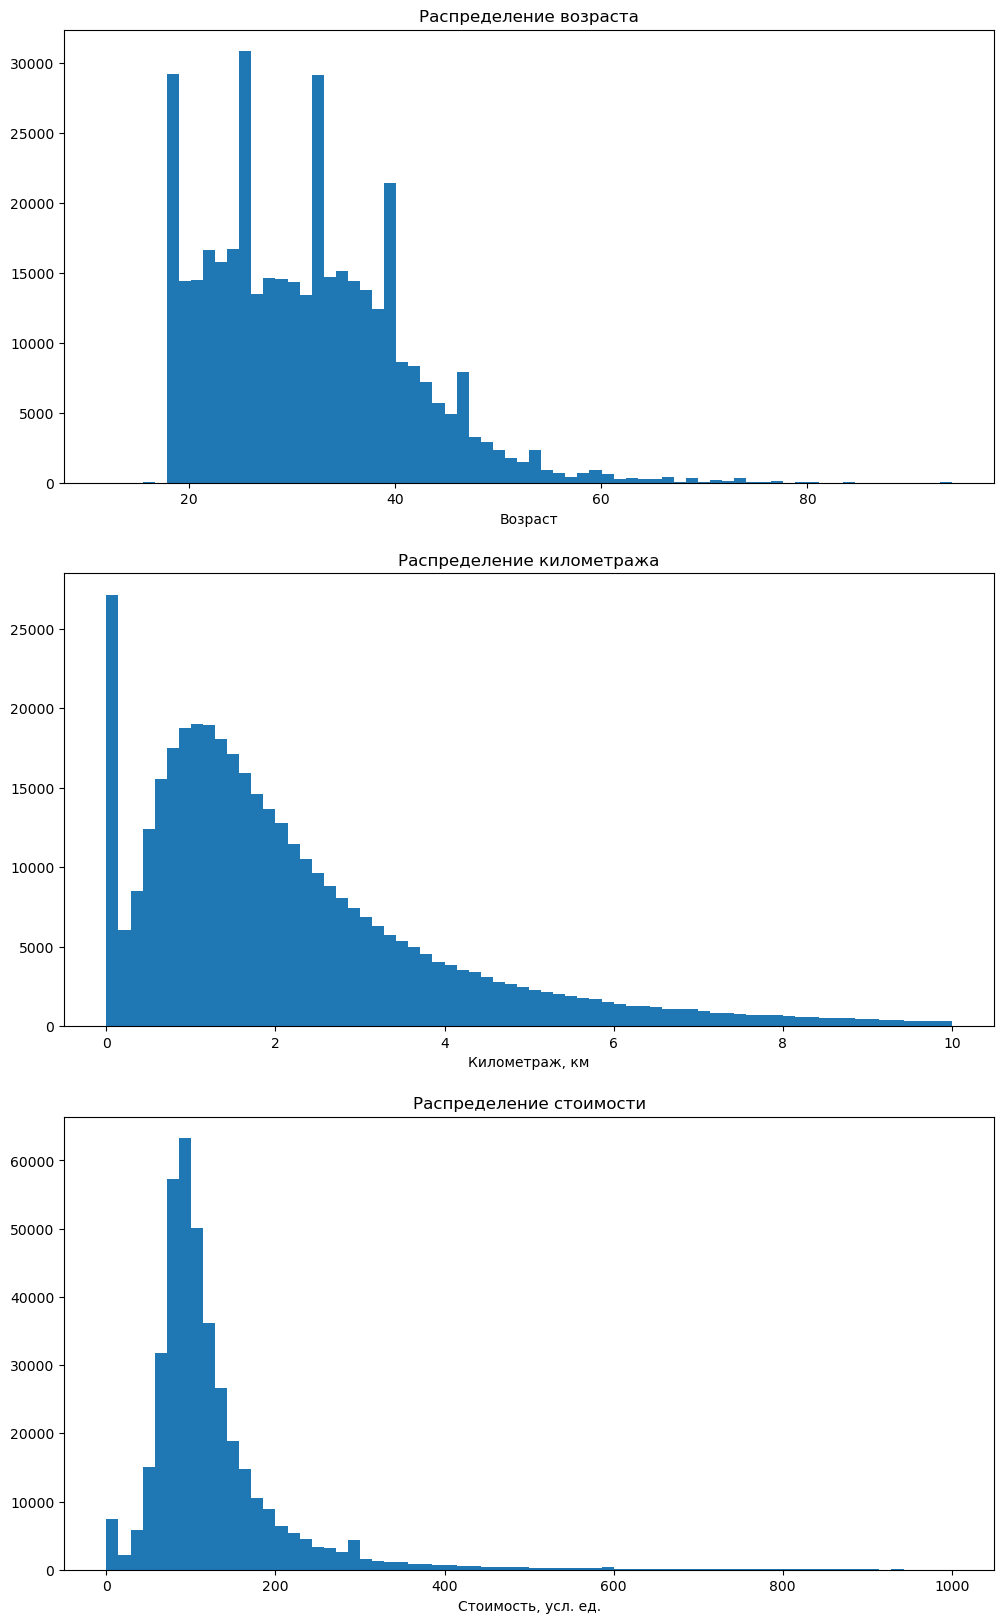

In [9]:
plt.figure(figsize=(12,20))
plt.subplot(3,1,1)
plt.hist(df['age'], bins=70)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.subplot(3,1,2)
plt.hist(df['distance_km'], range=[0, 10], bins=70)
plt.title('Распределение километража')
plt.xlabel('Километраж, км')
plt.subplot(3,1,3)
plt.hist(df['nominal_price_rub_amt'], range=[0, 1000], bins=70)
plt.title('Распределение стоимости')
plt.xlabel('Стоимость, усл. ед.')
plt.show()

И, наконец, для времени поездки:

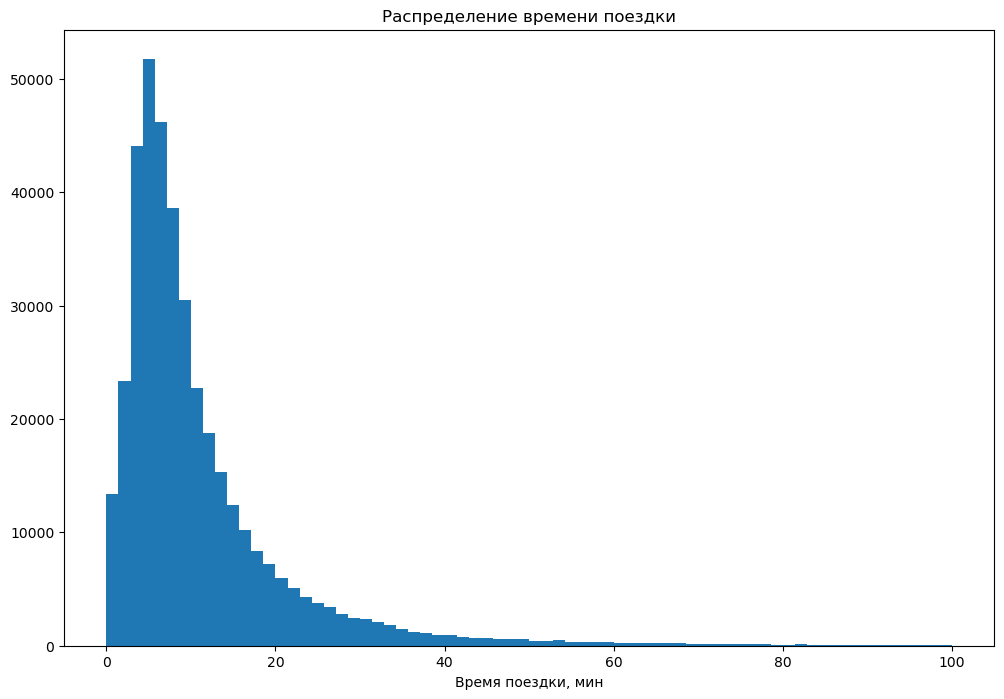

In [10]:
df['end_time'] = pd.to_datetime(df['book_end_dttm'])
df['start_time'] = pd.to_datetime(df['book_start_dttm'])
df['time'] = df['end_time'] - df['start_time'] 
df['duration_minutes'] = df['time'].dt.total_seconds() / 60
df['duration_minutes']
plt.figure(figsize=(12,8))
plt.hist(df['duration_minutes'], range=[0, 100], bins=70)
plt.title('Распределение времени поездки')
plt.xlabel('Время поездки, мин')
plt.show()

Посмотрим на категориальные пременные - пол, уровень образования, семейный статус, модель самоката:

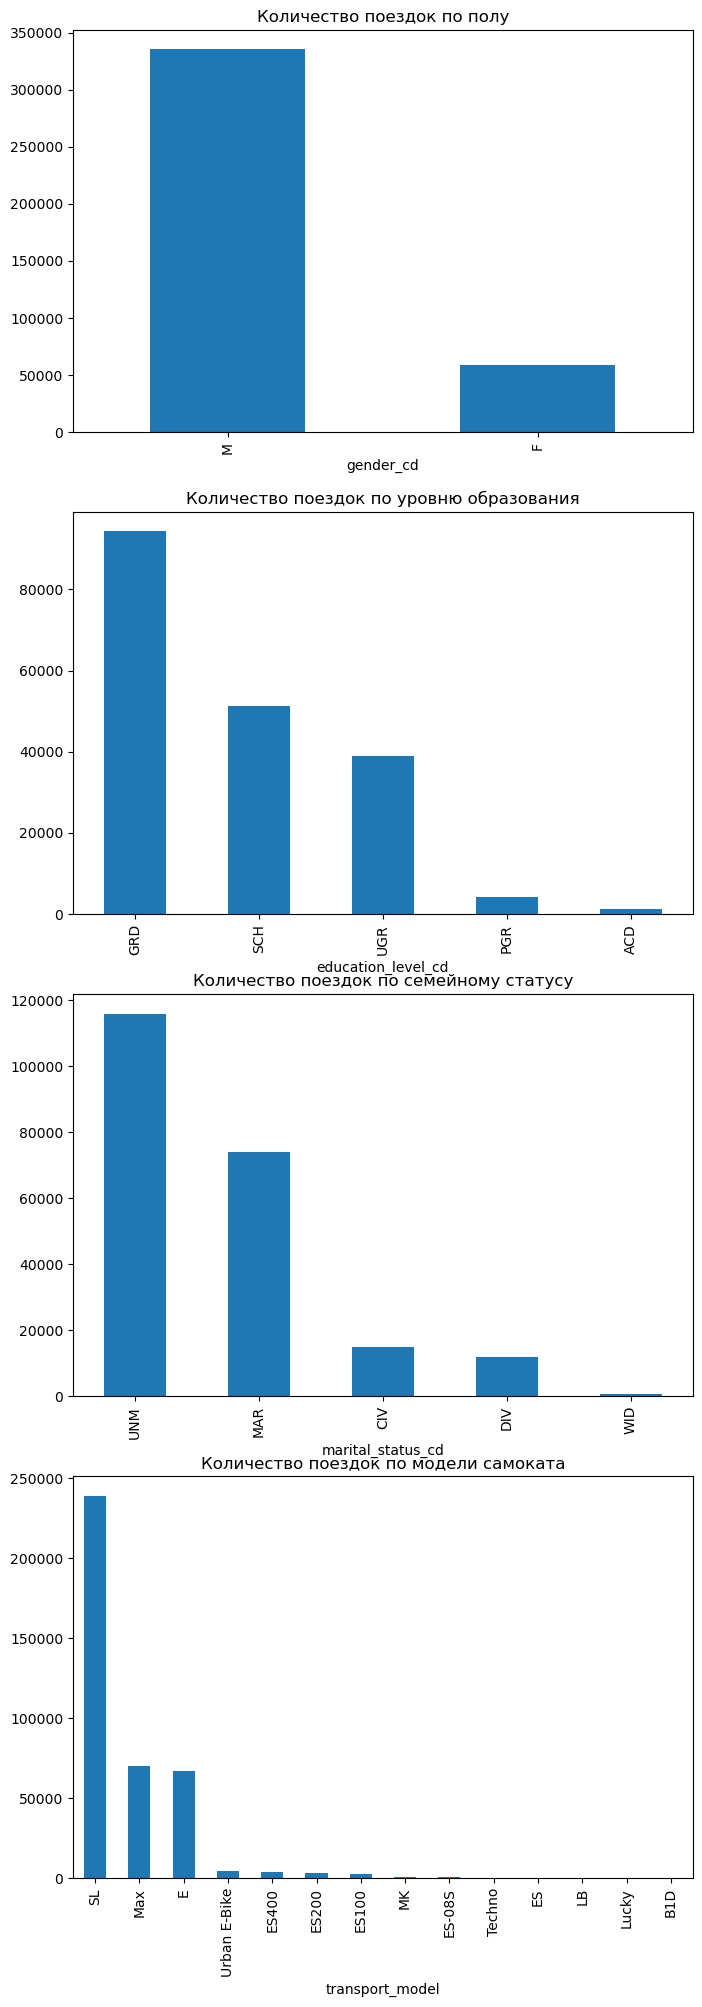

In [11]:
plt.figure(figsize=(8,24))
plt.subplot(4,1,1)
df['gender_cd'].value_counts().plot(kind='bar')
plt.title('Количество поездок по полу')
plt.subplot(4,1,2)
df['education_level_cd'].value_counts().plot(kind='bar')
plt.title('Количество поездок по уровню образования')
plt.subplot(4,1,3)
df['marital_status_cd'].value_counts().plot(kind='bar')
plt.title('Количество поездок по семейному статусу')
plt.subplot(4,1,4)
df['transport_model'].value_counts().plot(kind='bar')
plt.title('Количество поездок по модели самоката')
plt.show()

Возьмем в качестве независимой переменной пол. Посмотрим на средний километраж и среднюю длительность поездок:

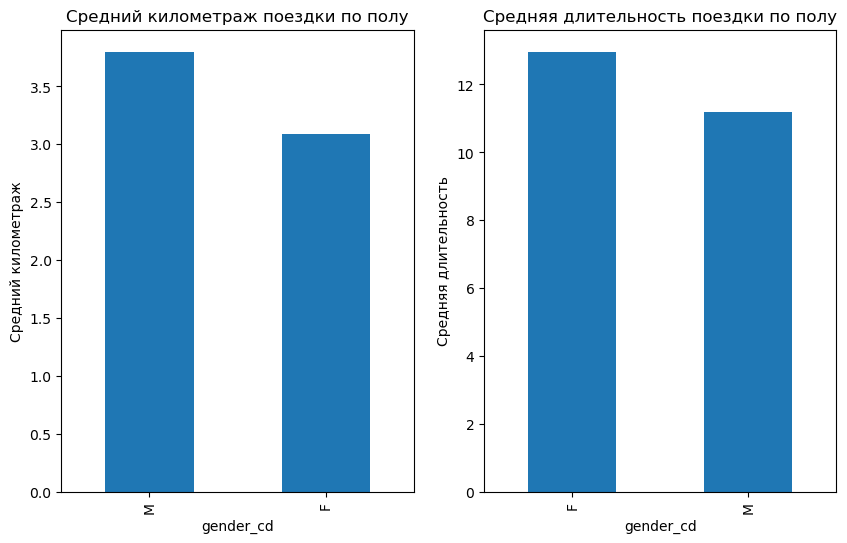

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
df.groupby('gender_cd')['distance_km'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Средний километраж поездки по полу')
plt.ylabel('Средний километраж')
plt.subplot(1,2,2)
df.groupby('gender_cd')['duration_minutes'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Средняя длительность поездки по полу')
plt.ylabel('Средняя длительность')
plt.show()

Ну, и кросс-таблица для того, чтобы найти взаимосвязь между семеным положением и полом (держим в голове, что для семейного статуса используется лишь половина данных):

In [12]:
pd.crosstab(df['gender_cd'], df['marital_status_cd'], normalize='index').style.background_gradient(cmap='Blues')

marital_status_cd,CIV,DIV,MAR,UNM,WID
gender_cd,,,,,
F,0.095946,0.073115,0.372049,0.441758,0.017132
M,0.064707,0.051349,0.335268,0.547558,0.001117


Введём месяц поездки и посмотрим на то, как зависит стоимость всех поездок от месяца:

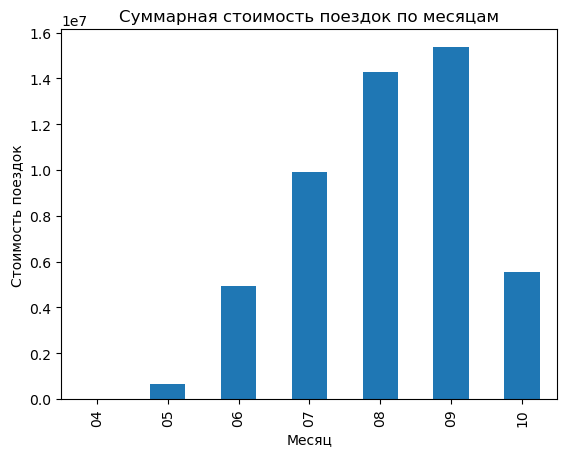

In [14]:
df['month'] = df['book_start_dttm'].str[5:7]
plt.figure()
df.groupby('month')['nominal_price_rub_amt'].sum().plot(kind='bar')
plt.title('Суммарная стоимость поездок по месяцам')
plt.ylabel('Стоимость поездок')
plt.xlabel('Месяц')
plt.show()

Не забудем про кэшбек и стоимость минуты поездки:

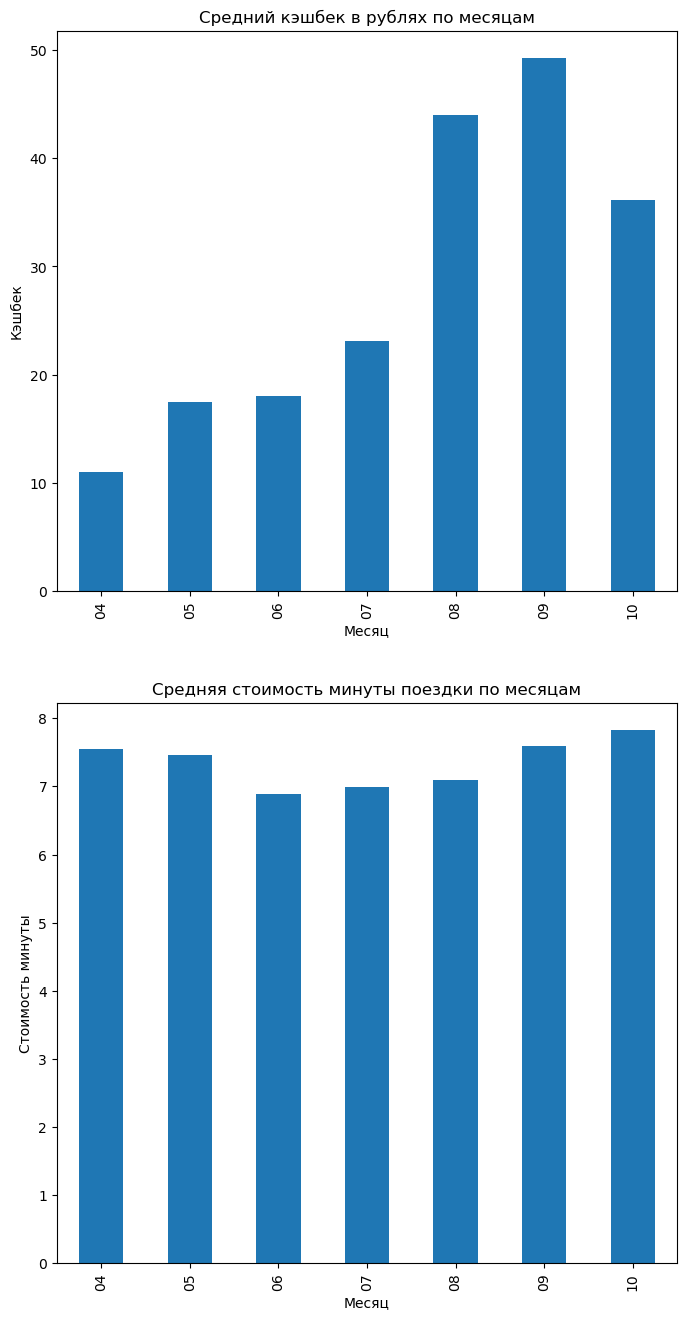

In [15]:
plt.figure(figsize=(8, 16))
plt.subplot(2,1,1)
df.groupby('month')['loyalty_accrual_rub_amt'].mean().plot(kind='bar')
plt.title('Средний кэшбек в рублях по месяцам')
plt.ylabel('Кэшбек')
plt.xlabel('Месяц')
plt.subplot(2,1,2)
df.groupby('month')['minute_cost'].mean().plot(kind='bar')
plt.title('Средняя стоимость минуты поездки по месяцам')
plt.ylabel('Стоимость минуты')
plt.xlabel('Месяц')
plt.show()

Наконец, выведем таблицу, полученную в ходе когортного анализа при помощи SQL-запроса:

In [2]:
cohort = pd.read_csv('SQL.csv')
cohort

,first_month,0-30,30-60,60-90,90-120,120-150,150-180,180-210
0,4,12850.722,10841.747,22125.115,22292.248,15951.169,8050.4097,1013.97003
1,5,1164561.000,686264.060,547627.600,500519.560,314657.380,18451.9020,NaN
2,6,6621766.500,3286415.200,2843703.200,1855022.000,331187.500,NaN,NaN
3,7,6697306.500,2935686.200,1946303.400,347588.470,NaN,NaN,NaN
4,8,9270330.000,2467611.000,379732.800,NaN,NaN,NaN,NaN
5,9,6981423.500,426283.900,NaN,NaN,NaN,NaN,NaN
6,10,935553.600,NaN,NaN,NaN,NaN,NaN,NaN
